In [1]:
import sys
sys.path.append('../')
from ProjectClass import Project,FileBuffer
from main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats

In [2]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject.pyecog')
fe = FeatureExtractor()

looking for h5_119
current animal: h5_119


In [3]:
annotation0 = project.current_animal.annotations.annotations_list[1]
it = project.current_animal.eeg_init_time
index = [i  for i in range(len(it)) if (0<(annotation0.getStart()-it[i])<3600) ][0]
fname = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1]+['features'])
f_vec = np.fromfile(fname,dtype='float64')

fmeta_file = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1] + ['fmeta'])
fmeta_dict = json.load(open(fmeta_file))


In [4]:
f_vec = f_vec.reshape((-1,fe.settings['number_of_features']))
f_vec[np.where(np.isnan(f_vec))] = 0

In [5]:
starts = [(annotation0.getStart()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]
ends = [(annotation0.getEnd()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]

f_labels = np.zeros(len(f_vec),dtype='bool')
for i in range(len(starts)-1) :
    s = int(np.floor(starts[i+1]))
    e = int(np.ceil(ends[i+1]))
    f_labels[s:e] = 1
    
f_vec_d  = np.hstack([f_vec,np.vstack([np.zeros(f_vec.shape[1]),np.diff(f_vec,axis=0)])])
f_vec_d  = f_vec
f_vec_d = f_vec_d-np.mean(f_vec_d,axis=0)
f_vec_d = f_vec_d/np.std(f_vec_d,axis = 0)

blanks = f_vec_d#[(1-f_labels).nonzero()[0],:]
seizures = f_vec_d[(f_labels).nonzero()[0],:]

blanks_mu  = blanks.mean(axis=0)
blanks_cov = (blanks-blanks_mu).T.dot((blanks-blanks_mu))/blanks.shape[0]
seizures_mu  = seizures.mean(axis=0)
seizures_cov = (seizures-seizures_mu).T.dot((seizures-seizures_mu))/seizures.shape[0]

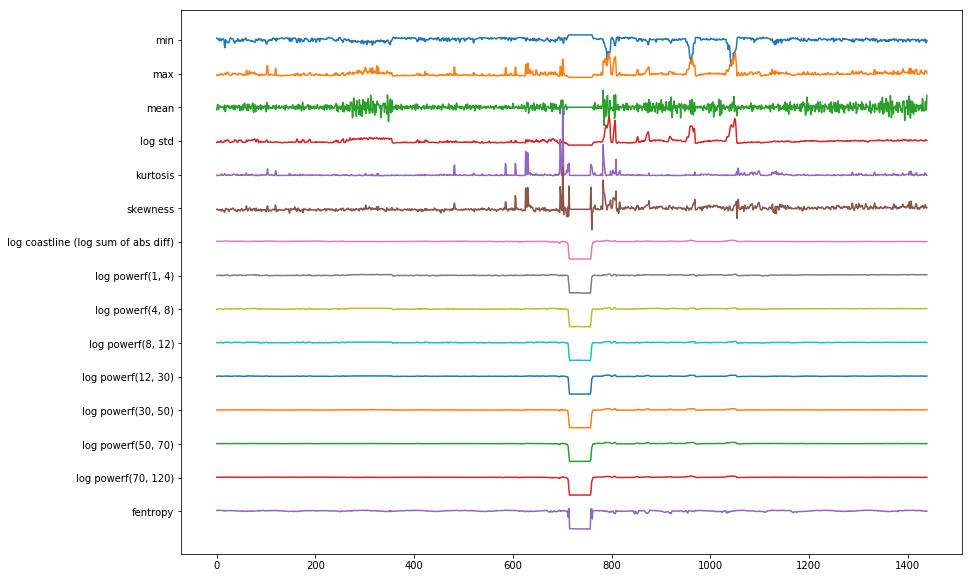

In [6]:

f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(f_vec_d,.5);

# plt.xlim([400,1000])
# plt.vlines(starts[1:],-15,0)
# plt.vlines(ends[1:],-15,0)
ax.set_yticks(range(0,-fe.settings['number_of_features'],-1))
ax.set_yticklabels(fe.settings['feature_labels'])

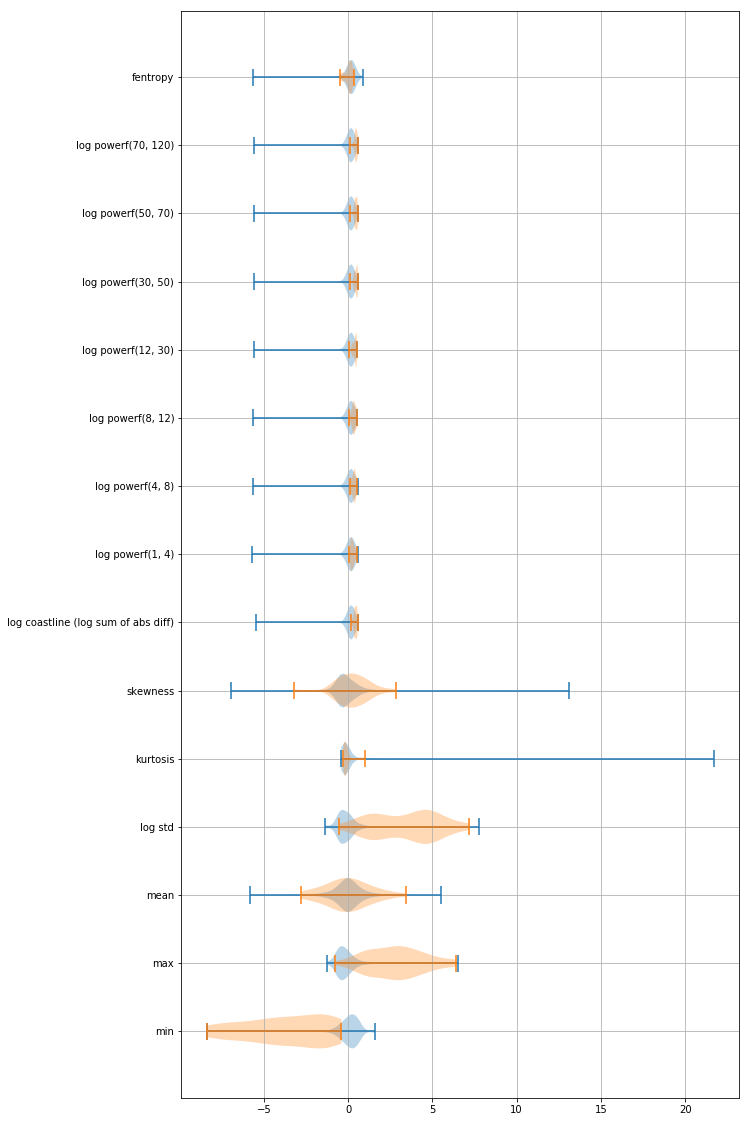

In [7]:
plt.figure(figsize=(10,20))
plt.violinplot(blanks,vert=False);
plt.violinplot(seizures,vert=False);
ax=plt.gca()
# ax.set_yticks(list(range(1,fe.settings['number_of_features']+1,1)) + 
#               list(range(fe.settings['number_of_features']+1,2*fe.settings['number_of_features']+1,1)))
# ax.set_yticklabels(fe.settings['feature_labels'] + ['d'+s+'/dt' for s in fe.settings['feature_labels']])
ax.set_yticks(list(range(1,fe.settings['number_of_features']+1,1)))
ax.set_yticklabels(fe.settings['feature_labels'])
plt.grid()

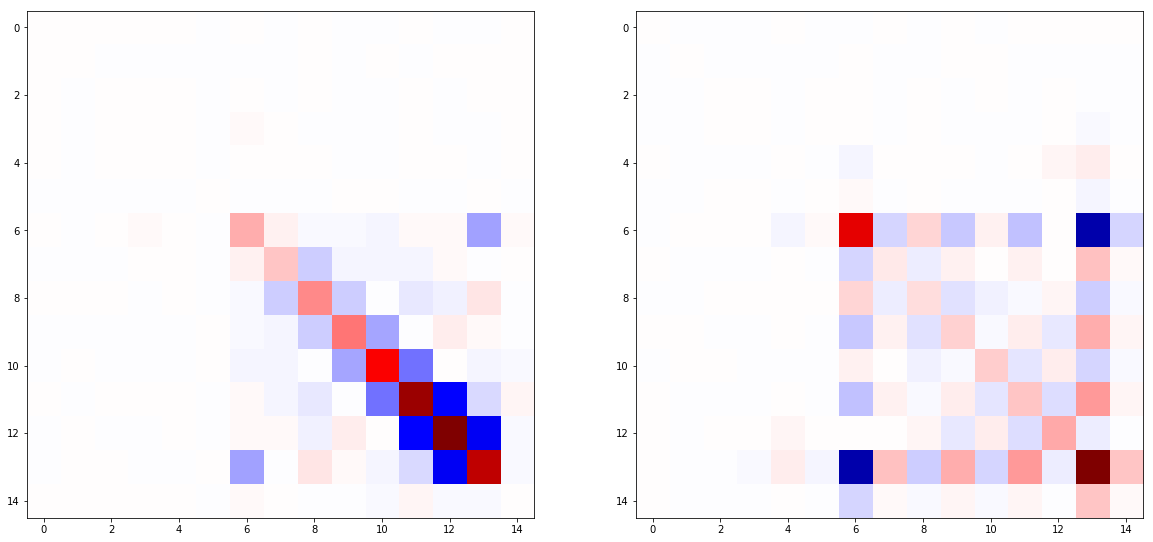

In [8]:
blanks_cov_i = np.linalg.inv(blanks_cov)
seizures_cov_i = np.linalg.inv(seizures_cov)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blanks_cov_i,cmap='seismic',vmin=-np.max(np.abs(blanks_cov_i)),vmax=np.max(np.abs(blanks_cov_i)))
plt.subplot(1,2,2)
plt.imshow(seizures_cov_i,cmap='seismic',vmin=-np.max(np.abs(seizures_cov_i)),vmax=np.max(np.abs(seizures_cov_i)))

In [9]:
fe.settings['feature_labels']

['min',
 'max',
 'mean',
 'log std',
 'kurtosis',
 'skewness',
 'log coastline (log sum of abs diff)',
 'log powerf(1, 4)',
 'log powerf(4, 8)',
 'log powerf(8, 12)',
 'log powerf(12, 30)',
 'log powerf(30, 50)',
 'log powerf(50, 70)',
 'log powerf(70, 120)',
 'fentropy']

In [10]:
@jit(nopython=True)
def MVGD_LL_jit(fdata,mu,inv_cov,LL,no_scale):
    k = fdata.shape[1]
    N = fdata.shape[0]
    scale = (1-no_scale)*((-k/2)*np.log(2*np.pi)+1/2*np.log(np.linalg.det(inv_cov[:,:])))
    for i in range(N):
        LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)

def MVGD_LL(fdata,mu,inv_cov,no_scale = False):
    LL = np.zeros(fdata.shape[0])
    MVGD_LL_jit(fdata,mu,inv_cov,LL, no_scale)
    return LL

@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

(400, 1000)

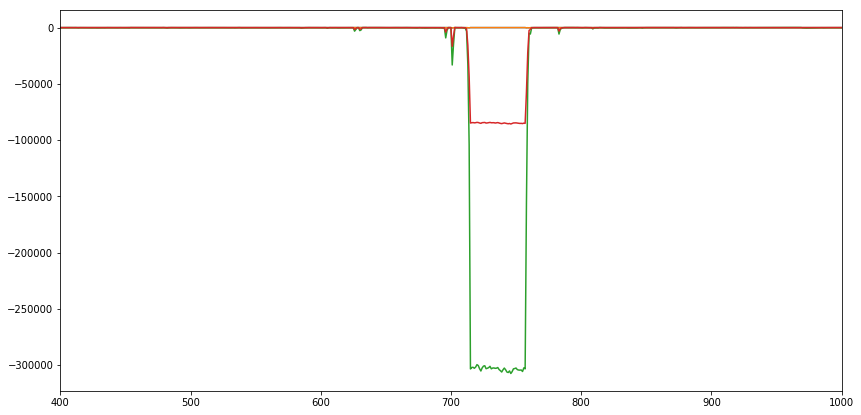

In [11]:
blanks_cov_i = np.linalg.inv(blanks_cov)
blanks_cov_ir = np.linalg.inv(blanks_cov+np.eye(len(blanks_cov))*blanks_cov.diagonal()/len(blanks))

seizures_cov_i = np.linalg.inv(seizures_cov)
seizures_cov_ir = np.linalg.inv(seizures_cov+np.eye(len(seizures_cov))*seizures_cov.diagonal()/len(seizures))

b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir)
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir)

plt.figure(figsize=(14,7))
plt.plot(b_LL)
plt.plot(b_LLr)
plt.plot(s_LL)
plt.plot(s_LLr)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')

plt.xlim(400,1000)

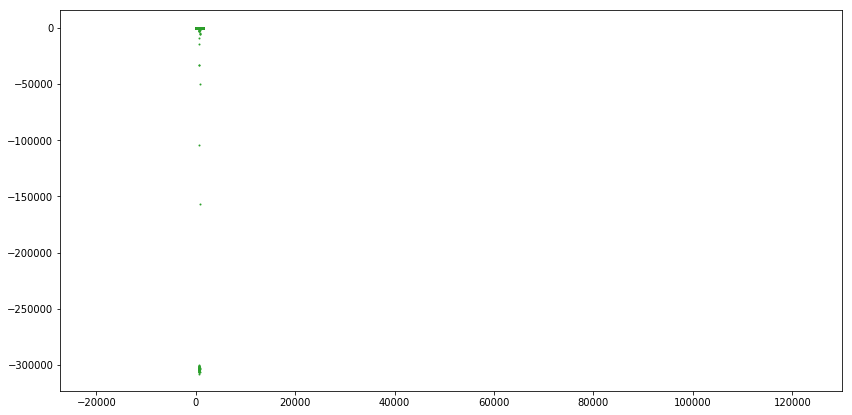

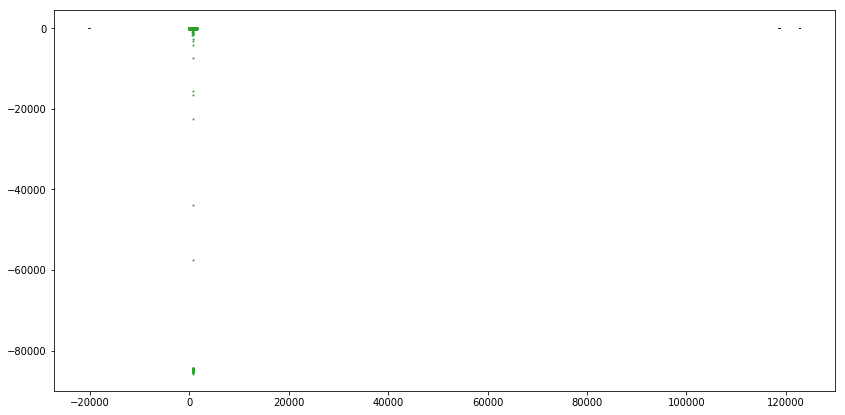

In [12]:
blanks_LL = MVGD_LL(blanks,blanks_mu,blanks_cov_i,no_scale=True)
seizures_LL = MVGD_LL(seizures,seizures_mu,seizures_cov_i,no_scale=True)

blank_bias = np.log(len(blanks)/(len(blanks)+len(seizures)))
seizure_bias = np.log(len(seizures)/(len(blanks)+len(seizures)))


b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)+ blank_bias
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)+ seizure_bias
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir) + blank_bias
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir) + seizure_bias

LL = np.array([b_LL.T,s_LL.T]).T
p  = LL2prob(LL) 

LLr = np.array([b_LLr.T,s_LLr.T]).T
pr  = LL2prob(LLr) 

plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(pr[:,1]*200,'.',markersize=1,color = [1,0,0,1])
plt.plot(b_LL,'.',markersize=2)
plt.plot(s_LL,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
# plt.xlim(400,1000)

plt.figure(figsize=(14,7))
plt.plot(pr[:,1]*200,'.',markersize=2)
plt.plot(b_LLr,'.',markersize=2)
plt.plot(s_LLr,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
# plt.xlim(400,1000)

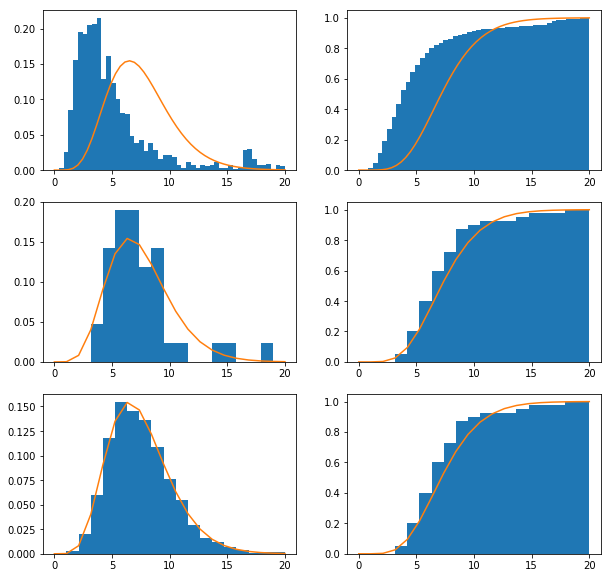

In [13]:
plt.figure(figsize=(10,10))
dof = f_vec.shape[1]
x = np.linspace(0,20,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-blanks_LL,bins = x,normed = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-blanks_LL,bins = x,normed = True,cumulative=True);
plt.plot(x,cum_chi2)

x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-seizures_LL,bins=x,normed=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-seizures_LL,bins = x,normed = True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,normed=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,normed = True,cumulative=True);
plt.plot(x,cum_chi2)





In [76]:
import classifier
importlib.reload(classifier)

<module 'classifier' from '../classifier.py'>

In [77]:
GC = classifier.GaussianClassifier(project,fe)

In [78]:
GC.train(project.animal_list[0:1])

Training with animal: h5_119
Transitions:19 file: 199 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567125024_2019-08-30-01-30-24_tids_[119].features
 [[0. 6. 0.]
 [6. 0. 0.]
 [0. 0. 0.]]
HMM.A:
 [[9.99989578e-01 1.04218052e-05 0.00000000e+00]
 [4.22535211e-02 9.57746479e-01 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [79]:
GC.blank_cov

array([[ 1.86272826e+04, -3.11061482e+04,  1.51294204e+00,
        -4.54493249e+03, -4.91415767e+02, -2.63116412e+01,
        -3.70046888e+01, -7.17881301e+01, -6.77503970e+01,
        -5.95596359e+01, -5.30945083e+01, -4.88942239e+01,
        -4.49345473e+01, -4.22906876e+01, -3.19493600e+00],
       [-3.11061482e+04,  8.61898043e+04,  1.91509106e+01,
         1.01022096e+04,  1.12015717e+03,  1.50079868e+02,
         5.85267496e+01,  1.44099663e+02,  1.36247205e+02,
         1.14303531e+02,  9.82916405e+01,  8.96352290e+01,
         8.05013265e+01,  7.38809158e+01,  5.40467324e+00],
       [ 1.51294204e+00,  1.91509106e+01,  1.56131955e+00,
         1.70710346e+00,  1.53088360e-01,  8.97082554e-02,
         2.02596316e-03,  2.23233480e-03,  9.86522847e-03,
         1.04386725e-02,  9.21426928e-03,  7.45711462e-03,
         6.49384658e-03,  5.39728752e-03, -8.82565902e-04],
       [-4.54493249e+03,  1.01022096e+04,  1.70710346e+00,
         1.45800719e+03,  8.89246060e+01,  1.27811708

In [80]:
(LLv,R2v,pf,timev) = GC.classify_animal(project.current_animal)

Combining results and generating annotations...te/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].fmeta1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569260959_2019-09-23-18-49-19_tids_[119].fmeta


../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1 seizure
len starts 0
[]
labels before delete ['seizure', 'artefact', 'flatline', '(auto)seizure', '(auto)outliers']
labels after ['seizure', 'artefact', 'flatline', '(auto)outliers']
found color for  seizure [242, 12, 12]
(auto)seizure (121, 6, 6) ['seizure', 'artefact', 'flatline', '(auto)outliers']
2 outliers
len starts 0
[]
labels before delete ['seizure', 'artefact', 'flatline', '(auto)outliers', '(auto)seizure']
labels after ['seizure', 'artefact', 'flatline', '(auto)seizure']
did not find color for outliers
(auto)outliers (127, 127, 127) ['seizure', 'artefact', 'flatline', '(auto)seizure']


../classifier.py:215: RuntimeWarning: invalid value encountered in less
  starts = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) > 0)[0]
../classifier.py:215: RuntimeWarning: invalid value encountered in greater
  starts = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) > 0)[0]
../classifier.py:216: RuntimeWarning: invalid value encountered in less
  ends = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) < 0)[0]
../classifier.py:216: RuntimeWarning: invalid value encountered in greater
  ends = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) < 0)[0]


In [81]:
pf.shape

(3, 2461208)

(-1000, 1000)

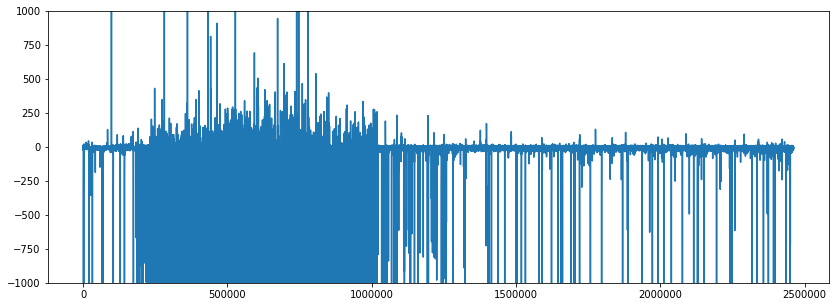

In [82]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.ylim(-1000,1000)

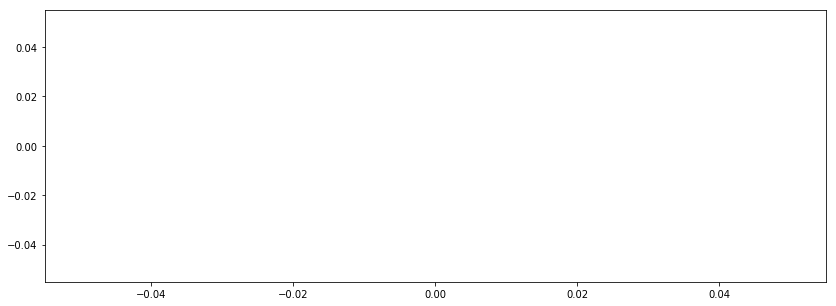

In [71]:
plt.figure(figsize=(14,5))
plt.plot(pf.T,'.', markersize=1)

In [53]:
project.current_animal.annotations

JSONDecodeError: Expecting value: line 1 column 104 (char 103)

In [54]:
project.project_file[:-7]

'/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject'

In [55]:
project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

{'project_file': '/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject.pyecog', 'title': 'Awesome Project', 'current_animal': 'h5_119', 'animal_list': [{'eeg_files': ['/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566408624_2019-08-21-18-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566412224_2019-08-21-19-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566415824_2019-08-21-20-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566419424_2019-08-21-21-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566423024_2019-08-21-22-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566426624_2019-08-21-23-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566430224_2019-08-22-00-30-24_tids_[119].meta', '/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566433824_2019-08-2

In [21]:
# f_vec_d = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
LL = GC.log_likelyhoods(f_vec,bias=True,no_scale=False)

../classifier.py:169: RuntimeWarning: divide by zero encountered in log
  bias_v = np.vstack((np.log(self.blank_npoints),*np.log(self.class_npoints)))


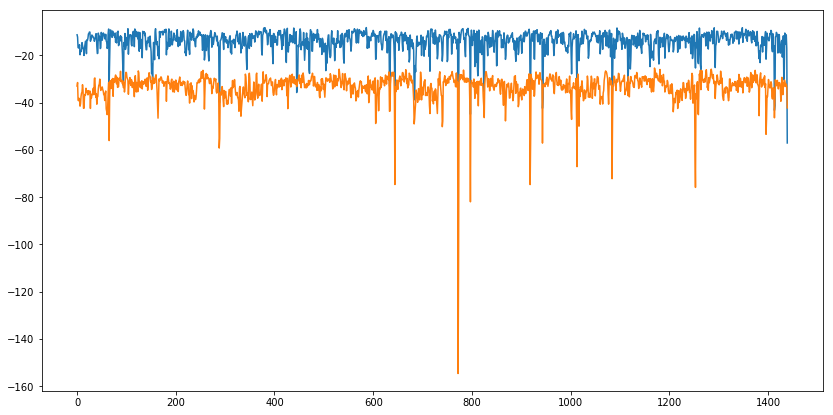

In [619]:
plt.figure(figsize=(14,7))
plt.plot(LL)

In [620]:
print(np.linalg.det(blanks_cov),np.linalg.det(GC.class_cov[0]))

0.000582672948028742 0.28223231073679556


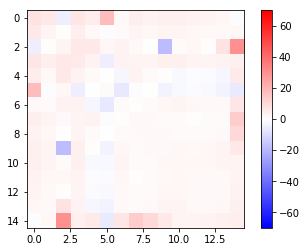

In [621]:
plt.imshow(GC.class_cov[0]/blanks_cov,cmap='bwr',vmin=-70,vmax=70)
plt.colorbar()

In [622]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [623]:
p = LL2prob(LL)

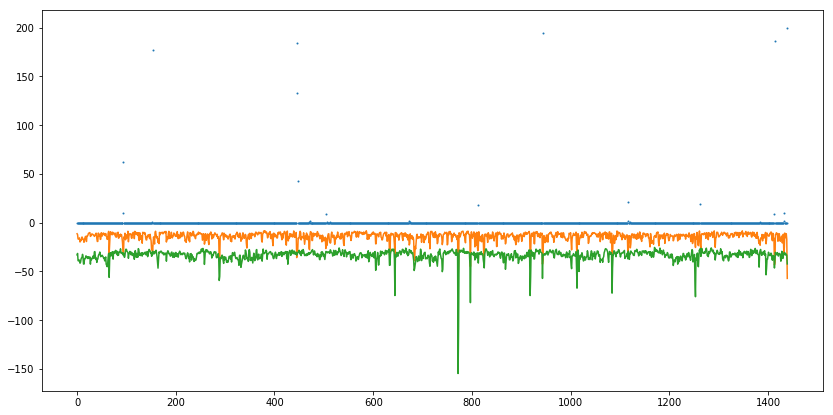

In [624]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

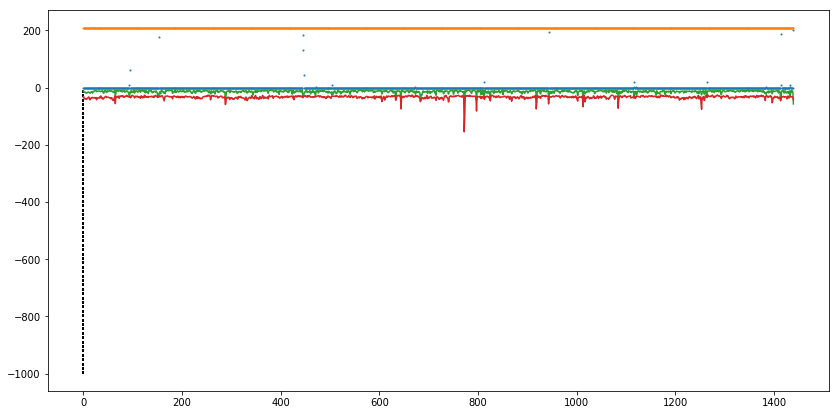

In [625]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(p[:,2]*200+210,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
plt.vlines(starts[1:],-1000,0,linestyles=':')
plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

In [699]:
LLv = []
R2v = []
drawplots = False

project.current_animal.eeg_files.sort()
for eegfname in project.current_animal.eeg_files:
    fname = '.'.join(eegfname.split('.')[:-1]+['features'])
    f_vec = np.fromfile(fname,dtype='float64')
    f_vec = f_vec.reshape((-1,fe.settings['number_of_features']))
#     f_vec = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
    LL = GC.log_likelyhoods(f_vec,bias=False,no_scale=False)
    R2 = GC.log_likelyhoods(f_vec,bias=False,no_scale=True)
    LLv.append(LL)
    R2v.append(R2)
    p  = LL2prob(LL) 
    if drawplots:
        plt.figure(figsize=(14,7))
        plt.plot(p[:,1]*200,'.',markersize=2)
        plt.plot(LL[:,0],'.',markersize=2)
        plt.plot(LL[:,1],'.',markersize=2)
        plt.vlines(starts[1:],-1000,0,linestyles=':')
        plt.vlines(ends[1:],-1000,0,linestyles=':')
        plt.title(eegfname)
        plt.show()
    # plt.xlim(400,1000)

    
LLv = np.vstack(LLv)
R2v = np.vstack(R2v)
pv  = LL2prob(LLv) 

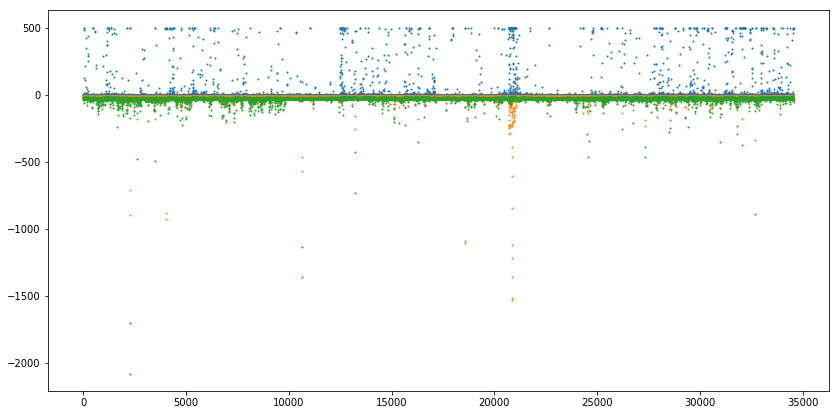

In [700]:
plt.figure(figsize=(14,7))
plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,0],'.',markersize=2)
plt.plot(LLv[:,1],'.',markersize=2)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')

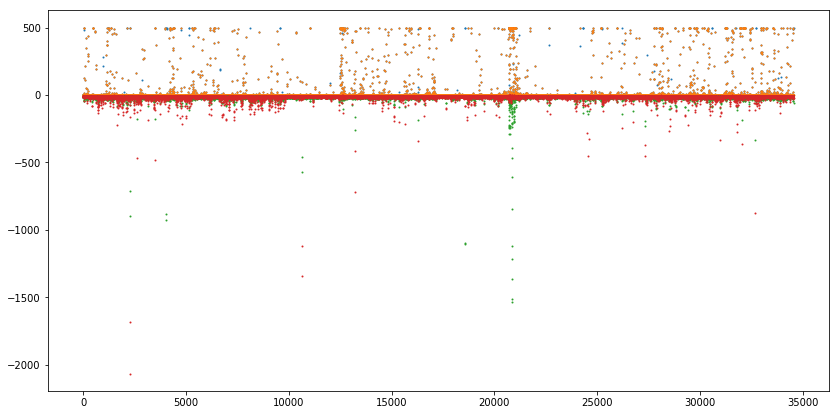

In [701]:
th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.figure(figsize=(14,7))


plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot((pv[:,1]*(-R2v[:,1]<th))*500,'.',markersize=2)
# plt.plot((-R2v[:,1]<th)*500,'-',markersize=2)
plt.plot(R2v[:,0],'.',markersize=2)
plt.plot(R2v[:,1],'.',markersize=2)

In [645]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [646]:
import hmm_pyecog
importlib.reload(hmm_pyecog)

<module 'hmm_pyecog' from '../hmm_pyecog.py'>

In [647]:
# HMM = hmm_pyecog.HMM_LL()
HMM = GC.hmm

In [649]:
HMM.A

array([[9.99956519e-01, 4.34807815e-05, 0.00000000e+00],
       [4.83870968e-02, 9.51612903e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [702]:
p  = LL2prob(LLv).T
pf = HMM.forward_backward(LLv.T)
starts = np.diff(((pf[1,:].T*(-R2v[:,1]<th)))>.5)>0
ends =  np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0

../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
../hmm_pyecog.py:284: RuntimeWarning: divide by zero encountered in log
  beta[:, t] = np.log(beta_t) + max_beta_t


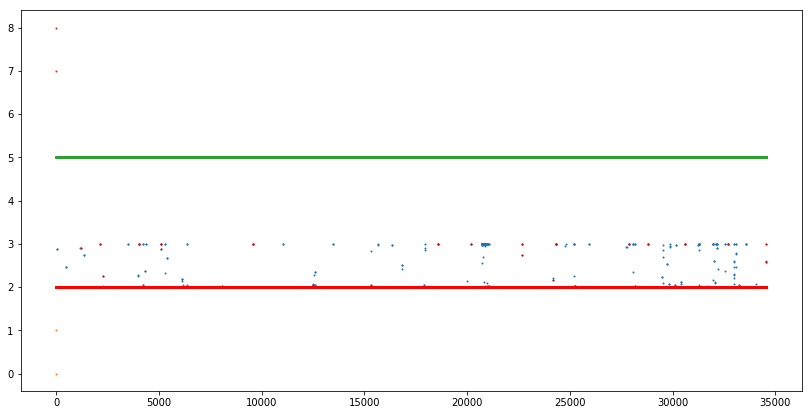

In [753]:
plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot((pf[1,:].T*(-R2v[:,1]>th))+2,'r.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
plt.plot(pf[2,:].T+5,'.',markersize=2)
plt.plot(p[2,:].T+7,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
# plt.xlim(20000,22050)

In [754]:
np.sum(np.diff((pf[1,:]>.5).astype('int')>0))


123

In [755]:
starts = np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))>0)[0]
ends =   np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0)[0]

In [756]:
len(starts)

55

In [757]:
np.tile(np.eye(10),(5,1,1)).shape

(5, 10, 10)

(20600, 21500)

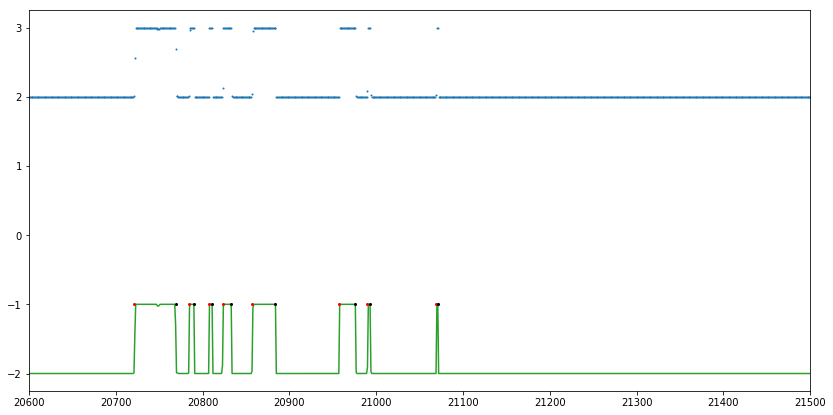

In [759]:
r = (20600,21500)

plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.plot((pf[1,:].T*(-R2v[:,1]<th))-2,'-',markersize=2)
plt.plot(starts,starts*0-1,'o',markersize=2,color='r')
plt.plot(ends,ends*0-1,'o',markersize=2,color='k')
plt.xlim(*r)

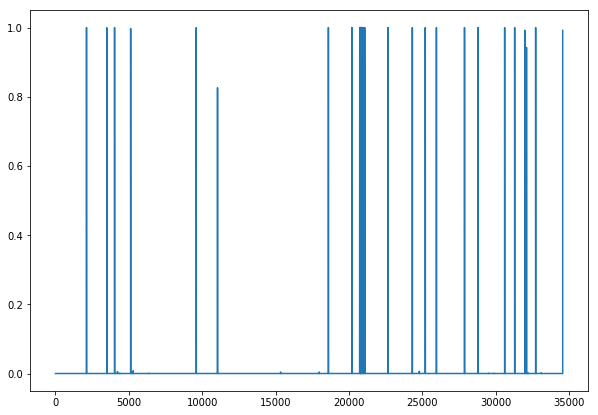

In [125]:
plt.figure(figsize=(10,7))
plt.plot(pf[1,:])
plt.show()

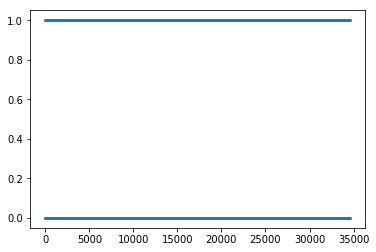

In [126]:
th = stats.chi2.isf(1e-1,15,scale=0.5)
plt.plot((-R2v[:,1]<th),'.',markersize=2)

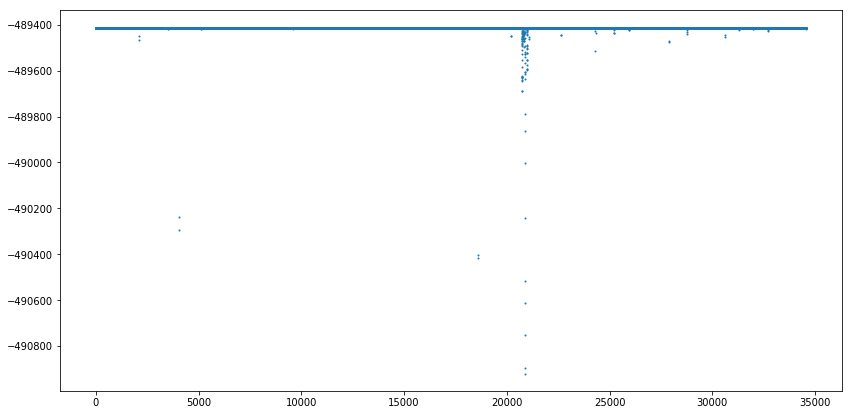

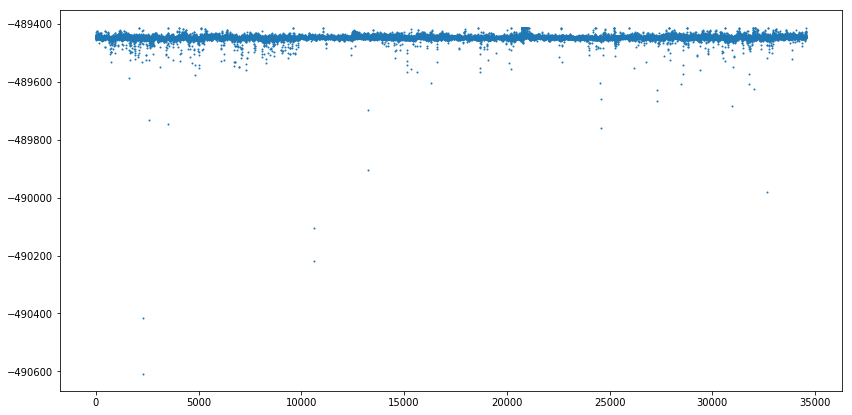

In [127]:

plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[0,:] + HMM.beta[0,:]).T,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[1,:] + HMM.beta[1,:]).T,'.',markersize=2)

(20000, 22000)

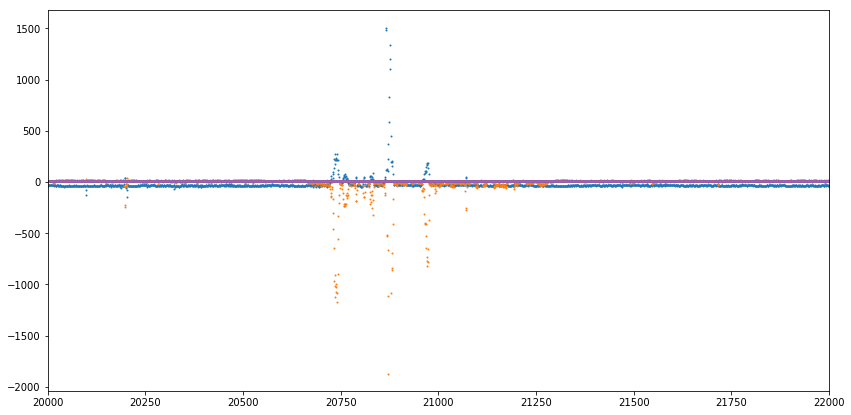

In [128]:
plt.figure(figsize=(14,7))
plt.plot(np.diff(HMM.beta.T+HMM.alpha.T,axis=1),'.',markersize=2)

plt.plot(HMM.posterior.T+10,'.',markersize=2)
plt.xlim(20000,22000)

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


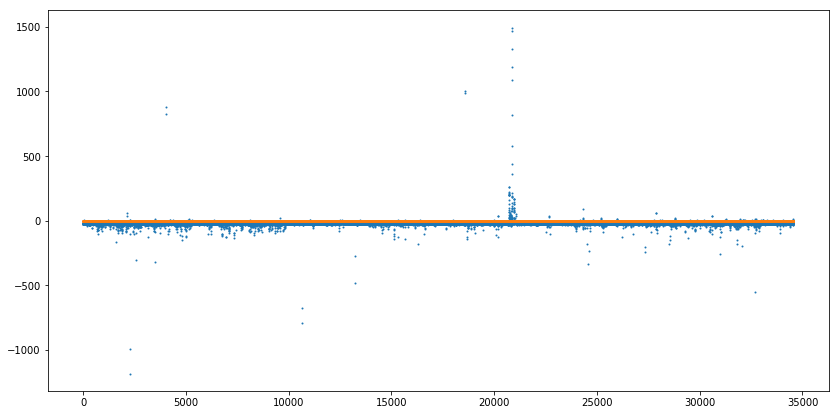

In [129]:
plt.figure(figsize=(14,7))
# plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,1] - LLv[:,0],'.',markersize=2)
plt.plot(np.exp(LLv[:,1] - LLv[:,0])/np.exp(LLv[:,1] - LLv[:,0]),'.',markersize=2)
# plt.plot(LLv[:,1],'.',markersize=2)
# plt.plot(HMM.phi.T,'.',markersize=2)
# plt.xlim(20000,22000)

In [130]:
LLf =(HMM.alpha+HMM.beta).T

In [131]:
dLLf = np.diff(LLf,axis=1)
dLLv = np.diff(LLv,axis=1)

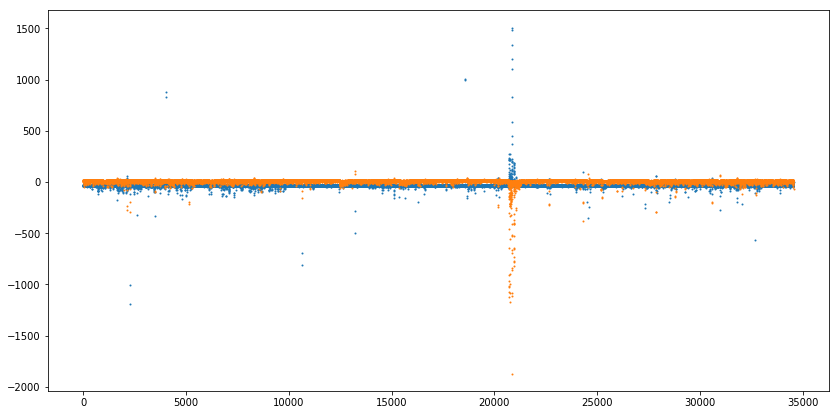

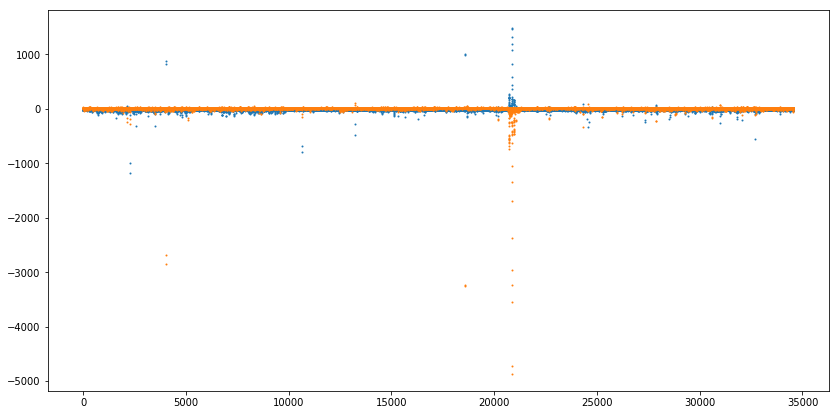

In [132]:
plt.figure(figsize=(14,7))
plt.plot(dLLf,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot(dLLv,'.',markersize=2)

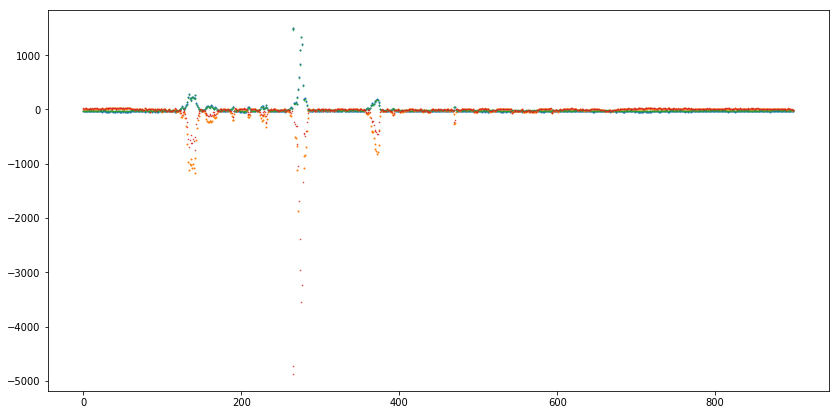

In [133]:
r = range(20600,21500)
plt.figure(figsize=(14,7))
plt.plot(dLLf[r],'.',markersize=2)
plt.plot(dLLv[r],'.',markersize=1)


In [405]:
a = {'b':[[1,2],[6,7]],
     'c':[[2,3],[8,9]]
    }
keys = ['b','c']

In [412]:
d = [(l[0],l[1],i+1) for i,key in enumerate(keys) for l in a[key]]
d

[(1, 2, 1), (6, 7, 1), (2, 3, 2), (8, 9, 2)]

In [413]:
d.sort()
d

[(1, 2, 1), (2, 3, 2), (6, 7, 1), (8, 9, 2)]

In [481]:
dt=.5
def transitions2matrix(t,dt,n):
    A = np.zeros((n+1,n+1))
    A[0,d[0][2]] +=1
    for i in range(len(t)-1):
        if t[i][1] >= t[i+1][0]-dt: # transitions between labled events
            A[t[i][2],t[i+1][2]] +=1
        else:  # transitions between labled events and blanks
            A[t[i][2],0]   +=1
            A[0,t[i+1][2]] += 1
    return A

def tansitions2rates(B,nblankpoints,nclasspoints):
    A = B
    A[0,0] = nblankpoints - np.sum(A[0,:])
    A[0,:] /= np.sum(A[0,:])
    for i in range(len(nclasspoints)):
        if nclasspoints[i]:
            A[i+1,i+1] = nclasspoints[i] - np.sum(A[i+1,:])
            A[i+1,:] /= np.sum(A[i+1,:])
        else: # For classes that do not occur, default to transition to blanks
            A[i+1,:] = 0
            A[i+1,0] = 1
    return A

In [482]:
A = np.zeros((3,3),dtype='float64')
A = transitions2matrix(d,.5,3)

In [483]:
B  = tansitions2rates(A,100,[10,5,0])

In [484]:
B

array([[0.97, 0.02, 0.01, 0.  ],
       [0.1 , 0.8 , 0.1 , 0.  ],
       [0.2 , 0.  , 0.8 , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [661]:
tv = []
for i in range(10):
    t =np.arange(100)
    tv.append(t)
tvs = np.hstack(tv)

In [662]:
tvs.shape

(1000,)